#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2018


# Homework 1:  Basic Machine Learning + Learning to Rank 

### 100 points [5% of your final grade]

### Due: Monday, February 12 by 11:59pm

*Goals of this homework:* In this homework you will get hands-on experience with (i) the basics of machine learning (e.g. train/test data, cross-validation, different classifiers) and interpreting results; and (ii) learning to rank.

*Submission Instructions:* To submit your homework, rename this notebook as UIN_hw#.ipynb. For example, this homework submission would be: YourUIN_hw1.ipynb. Submit this notebook via ecampus. Your notebook should be completely self-contained, with the results visible in the notebook. 

*Late submission policy:* For this homework, you may use up to three of your late days, meaning that no submissions will be accepted after Thursday, February 15 at 11:59pm.

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by **filling out the Collaboration Declarations at the bottom of this notebook**. 

*Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.*

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Part 1: Basics of ML (70 points)

For this part, we're going to get familiar with scikit-learn (a great ML toolkit that is very popular) and the major issues in training a model, testing it, and interpreting the results. Our goal in this assignment is to build a classifier to determine if a Yelp review is "food-relevant" or not.

## Dataset: Yelp review data

First, you will need to download the training_data.json file from the Resources tab on Piazza, a collection of 40,000 json-encoded Yelp reviews we sampled from the [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge).

You'll see that each line corresponds to a review on a particular business. The label (class) information of each review is in the "label" field. It is **either "Food-relevant" or "Food-irrelevant"**.

## Part 1.1: Parsing Yelp (15 points)

For this first part, we will build a parser for extracting tokens from the **review text** only. First, you should tokenize each review using **whitespaces and punctuations as delimiters**. Do not remove stopwords. You should apply casefolding (lower case everything) and use the [nltk Porter stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter) ... you may need to install nltk if you don't have it already. 

In [21]:
import os
import string
import re
from string import punctuation
import json
from nltk.stem.porter import *
ps = PorterStemmer()
import jsonlines as js
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, classification_report

In [2]:
word_list = []
label_list = []
stem_word_list = []

with js.open('training_data.json') as reader:
    for obj in reader:
        text = obj["text"]
        text = text.lower()
        text = re.sub(r'[^\w\s]',' ',text)
        text = " ".join(ps.stem(word) for word in text.split(" "))
        label_list.append(obj["label"])
        stem_word_list.append(text)
        word_list.append(text)
        
word_df = pd.DataFrame(word_list, columns=["Text"])
word_df["Label"] = label_list
word_df["Clean Text"] = stem_word_list
print(word_df.shape)
word_df.head()

(40000, 3)


,Text,Label,Clean Text
0,dr goldberg offer everyth i look for in a gen...,Food-irrelevant,dr goldberg offer everyth i look for in a gen...
1,unfortun the frustrat of be dr goldberg s pa...,Food-irrelevant,unfortun the frustrat of be dr goldberg s pa...
2,dr goldberg ha been my doctor for year and i ...,Food-irrelevant,dr goldberg ha been my doctor for year and i ...
3,been go to dr goldberg for over 10 year i th...,Food-irrelevant,been go to dr goldberg for over 10 year i th...
4,got a letter in the mail last week that said d...,Food-irrelevant,got a letter in the mail last week that said d...


In [3]:
dict_word = {}
def parser(s):
    for line in word_df[s]:
               for word in line.split():
                    if word not in dict_word:
                        dict_word[word] = 1
                    else:
                        dict_word[word] = dict_word[word] + 1
    return dict_word

In [4]:
words = parser("Text")

### Unique tokens?

Once you have your parser working, you should report here the size of your feature space. That is, how many unique tokens do you find?

In [5]:
print(len(words))

37405


### The Most Popular Words

Great, now we can tokenize the documents. Let's make a list of the most popular words in our reviews. For this step, you should maintain a count of how many times each word occurs. Then you should print out the top-20 words in your reviews.

Your output should look like this:

Rank Token Count

1 awesome 78

... ...

In [6]:
import operator
sorted_dict_word = sorted(words.items(), key=operator.itemgetter(1),reverse=True)
for i in range(20):
    print(sorted_dict_word[i])

(u'the', 246142)
(u'i', 168971)
(u'and', 168589)
(u'a', 135513)
(u'to', 128139)
(u'it', 78865)
(u'of', 76237)
(u'wa', 74017)
(u'is', 63456)
(u'for', 60867)
(u'in', 60523)
(u'that', 50804)
(u'my', 49013)
(u'you', 45870)
(u'they', 43635)
(u'thi', 39937)
(u'with', 39340)
(u'have', 39072)
(u'but', 37967)
(u'on', 35394)


### Zipf's Law

Recall in class our discussion of Zipf's law. Let's see if this law applies to our Yelp reviews. You should use matplotlib to plot the log-base10 term counts on the y-axis versus the log-base10 rank on the x-axis. Your aim is to create a figure like the one in Figure 5.2 of the textbook.

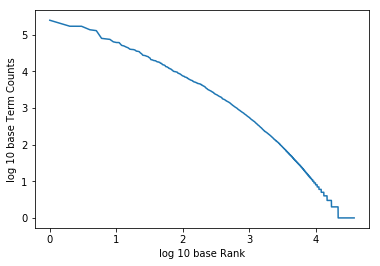

In [9]:
import matplotlib.pyplot as plt

rank_dict = {}
for i in range(len(sorted_dict_word)):
    rank_dict[i+1] = sorted_dict_word[i][1]
xaxis = np.log10(rank_dict.keys())
yaxis = np.log10(rank_dict.values())
plt.plot(xaxis, yaxis)
plt.xlabel("log 10 base Rank")
plt.ylabel("log 10 base Term Counts")
plt.show()

What do you observe? Is this consistent with Zipf's law?

The plot obtained above is consistent with Zipf's law as we can see the most common word "the" occurs the maximum number of times in the yelp reviews. The words "i" and "and" occur nearly the same number of times which is about 2/3 of the number of times "the" occurs. Ideally, this fraction should be 1/2 as suggested by Zipf's law but as we're considering a skewed sample space, so it is not expected to get the exact same results.

## Part 1.2: Feature Represenation (10 points)

In this part you will build feature vectors for each review. This will be input to our ML classifiers. You should call your parser from earlier, using all the same assumptions (e.g., casefolding, stemming). Each feature value should be the term count for that review.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
reviews = word_df["Clean Text"]
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X = vectorizer.fit_transform(reviews)
print X.shape
X

(40000, 37405)


<40000x37405 sparse matrix of type '<type 'numpy.int64'>'
	with 3224978 stored elements in Compressed Sparse Row format>

In [8]:
vectorizer.get_feature_names()[:25]

[u'0',
 u'00',
 u'000',
 u'0003',
 u'000707',
 u'000th',
 u'000x',
 u'001',
 u'003',
 u'007',
 u'00am',
 u'00p',
 u'00pm',
 u'01',
 u'0100',
 u'0170',
 u'0175',
 u'01pm',
 u'02',
 u'0227',
 u'03',
 u'0302',
 u'037',
 u'038',
 u'03a']

## Part 1.3: Machine Learning Basics (30 points)

In this part you will evaluate a bunch of classifiers -- kNN, Decision tree, Naive Bayes, and SVM -- on the feature vectors generated in the previous task in two different settings. **You do not need to implement any classifier from scratch. You may use scikit-learn's built-in capabilities.**

### Setting 1: Splitting data into train-test 

In the first setting, you should treat the first 70% of your data as training. The remaining 30% should be for testing. 

### Setting 2: Using 5 fold cross-validation

In the second setting, use 5-folk cross-validation. 

### What to report

* Report the overall accuracy for both settings.
* For the class "Food-relevant", report the precision and recall for both settings.
* For the class "Food-irrelevant", report the precision and recall for both settings.

In [19]:
from sklearn.model_selection import train_test_split

Y = []
target_names = ["Food-irrelevant", "Food-relevant"]
for w in word_df["Label"]:
    if w == "Food-irrelevant":
        Y.append(0)
    else:
        Y.append(1)
Y = np.array(Y)

X_train_set1, X_test_set1, Y_train_set1, Y_test_set1 = train_test_split(X, Y, test_size=0.3, random_state=42)
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [14]:
print(X_train_set1.shape, Y_test_set1.shape)

((28000, 37405), (12000,))


## KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier


neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_set1, Y_train_set1)

Y_predict = neigh.predict(X_test_set1)

print "KNN:"
print "Setting 1:"
average_precision = average_precision_score(Y_test_set1, Y_predict)
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))

print "Accuracy:"
print accuracy_score(Y_test_set1, Y_predict)

print "Setting 2:"
print(classification_report(Y_test_set1,Y_predict,target_names=target_names,digits=2)) 

acc = 0
for train_index, test_index in kf.split(X):
    X_train_set2, X_test_set2, Y_train_set2, Y_test_set2 = X[train_index],X[test_index],Y[train_index],Y[test_index]
    neigh.fit(X_train_set2, Y_train_set2)
    Y_predict = neigh.predict(X_test_set2)
    average_precision = average_precision_score(Y_test_set2, Y_predict)
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))
    
    acc += accuracy_score(Y_test_set2, Y_predict)
    print(classification_report(Y_test_set2,Y_predict,target_names=target_names,digits=2))
print "Accuracy:", acc/5

KNN:
Setting 1:
Average precision-recall score: 0.660
Accuracy:
0.731
Setting 2:
                 precision    recall  f1-score   support

Food-irrelevant       0.79      0.63      0.70      5999
  Food-relevant       0.69      0.83      0.76      6001

    avg / total       0.74      0.73      0.73     12000

Average precision-recall score: 0.811
                 precision    recall  f1-score   support

Food-irrelevant       0.52      0.58      0.55      2201
  Food-relevant       0.83      0.79      0.81      5799

    avg / total       0.75      0.73      0.74      8000

Average precision-recall score: 0.767
                 precision    recall  f1-score   support

Food-irrelevant       0.65      0.56      0.60      2727
  Food-relevant       0.79      0.84      0.81      5273

    avg / total       0.74      0.75      0.74      8000

Average precision-recall score: 0.826
                 precision    recall  f1-score   support

Food-irrelevant       0.60      0.66      0.63      23

##  Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_set1, Y_train_set1)

Y_predict = clf.predict(X_test_set1)

print "Decision Tree:"
print "Setting 1:"
average_precision = average_precision_score(Y_test_set1, Y_predict)
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))

print "Accuracy"
print accuracy_score(Y_test_set1, Y_predict)

print(classification_report(Y_test_set1,Y_predict,target_names=target_names,digits=2)) 
print "Setting 2:"
acc=0
for train_index, test_index in kf.split(X):
    X_train_set2, X_test_set2, Y_train_set2,Y_test_set2 = X[train_index], X[test_index],Y[train_index],Y[test_index]
    clf.fit(X_train_set2, Y_train_set2)
    Y_predict = clf.predict(X_test_set2)
    average_precision = average_precision_score(Y_test_set2, Y_predict)
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))
    acc += accuracy_score(Y_test_set2, Y_predict)
    print(classification_report(Y_test_set2,Y_predict,target_names=target_names,digits=2)) 
print("Accuracy:", acc/5)

Decision Tree:
Setting 1:
Average precision-recall score: 0.834
Accuracy
0.8805
                 precision    recall  f1-score   support

Food-irrelevant       0.88      0.88      0.88      5999
  Food-relevant       0.88      0.88      0.88      6001

    avg / total       0.88      0.88      0.88     12000

Setting 2:
Average precision-recall score: 0.902
                 precision    recall  f1-score   support

Food-irrelevant       0.70      0.83      0.76      2201
  Food-relevant       0.93      0.86      0.90      5799

    avg / total       0.87      0.85      0.86      8000

Average precision-recall score: 0.894
                 precision    recall  f1-score   support

Food-irrelevant       0.75      0.89      0.81      2727
  Food-relevant       0.94      0.84      0.89      5273

    avg / total       0.87      0.86      0.86      8000

Average precision-recall score: 0.907
                 precision    recall  f1-score   support

Food-irrelevant       0.72      0.87      0.

/Users/Yash/Code/deep_learning/Anaconda/anaconda3/envs/cs670/lib/python2.7/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/Yash/Code/deep_learning/Anaconda/anaconda3/envs/cs670/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_set1, Y_train_set1)

Y_predict = clf.predict(X_test_set1)
print "Naive Bayes:"
print "Setting 1:"
average_precision = average_precision_score(Y_test_set1, Y_predict)
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))

print "Accuracy"
print accuracy_score(Y_test_set1, Y_predict)

print(classification_report(Y_test_set1,Y_predict,target_names=target_names,digits=2)) 
print "Setting 2:"
acc = 0
for train_index, test_index in kf.split(X):
    X_train_set2, X_test_set2, Y_train_set2,Y_test_set2 = X[train_index], X[test_index],Y[train_index],Y[test_index]
    clf.fit(X_train_set2, Y_train_set2)
    Y_predict = clf.predict(X_test_set2)
    average_precision = average_precision_score(Y_test_set2, Y_predict)
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))
    
    acc += accuracy_score(Y_test_set2, Y_predict)
    
    print(classification_report(Y_test_set2,Y_predict,target_names=target_names,digits=2)) 
print("Accuracy:", acc/5)


Naive Bayes:
Setting 1:
Average precision-recall score: 0.920
Accuracy
0.9470833333333334
                 precision    recall  f1-score   support

Food-irrelevant       0.95      0.94      0.95      5999
  Food-relevant       0.94      0.96      0.95      6001

    avg / total       0.95      0.95      0.95     12000

Setting 2:
Average precision-recall score: 0.937
                 precision    recall  f1-score   support

Food-irrelevant       0.80      0.89      0.84      2201
  Food-relevant       0.96      0.92      0.94      5799

    avg / total       0.91      0.91      0.91      8000

Average precision-recall score: 0.939
                 precision    recall  f1-score   support

Food-irrelevant       0.89      0.91      0.90      2727
  Food-relevant       0.96      0.94      0.95      5273

    avg / total       0.93      0.93      0.93      8000

Average precision-recall score: 0.943
                 precision    recall  f1-score   support

Food-irrelevant       0.88      0.

## SVM

In [20]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train_set1, Y_train_set1)

Y_predict = clf.predict(X_test_set1)

print "SVM:"
print "Setting 1:"
average_precision = average_precision_score(Y_test_set1, Y_predict)
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))
print "Accuracy: "
print accuracy_score(Y_test_set1, Y_predict)

print(classification_report(Y_test_set1,Y_predict,target_names=target_names,digits=2)) 
print "Setting 2:"
acc = 0
for train_index, test_index in kf.split(X):
    X_train_set2, X_test_set2, Y_train_set2,Y_test_set2 = X[train_index], X[test_index],Y[train_index],Y[test_index]
    clf.fit(X_train_set2, Y_train_set2)
    Y_predict = clf.predict(X_test_set2)
    average_precision = average_precision_score(Y_test_set2, Y_predict)
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))
    acc += accuracy_score(Y_test_set2, Y_predict)
    print(classification_report(Y_test_set2,Y_predict,target_names=target_names,digits=2))
print("Accuracy:", acc/5)

SVM:
Setting 1:
Average precision-recall score: 0.835
Accuracy: 
0.86975
                 precision    recall  f1-score   support

Food-irrelevant       0.84      0.91      0.88      5999
  Food-relevant       0.91      0.83      0.86      6001

    avg / total       0.87      0.87      0.87     12000

Setting 2:
Average precision-recall score: 0.853
                 precision    recall  f1-score   support

Food-irrelevant       0.44      0.94      0.60      2201
  Food-relevant       0.96      0.55      0.70      5799

    avg / total       0.82      0.65      0.67      8000

Average precision-recall score: 0.858
                 precision    recall  f1-score   support

Food-irrelevant       0.58      0.96      0.72      2727
  Food-relevant       0.97      0.64      0.77      5273

    avg / total       0.84      0.75      0.76      8000

Average precision-recall score: 0.868
                 precision    recall  f1-score   support

Food-irrelevant       0.50      0.98      0.66     

/Users/Yash/Code/deep_learning/Anaconda/anaconda3/envs/cs670/lib/python2.7/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/Yash/Code/deep_learning/Anaconda/anaconda3/envs/cs670/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Part 1.4: Analyzing your results (5 points) 

OK, now that you have tried four different classifiers, what do you observe? Any conclusions you can draw? Give us one or two paragraphs summarizing your findings.

After running four classifiers on the feature vector, I found that out of all Naive Bayes provides the best accuracy of 94.7% for setting 1 and 93.5% for setting 2. It also provides the best precision-recall score of 0.92. There are 4 types of Naive Bayes classifiers, for the purposes of this homework Multinomial Naive Bayes was used. This result is a little weird because ideally SVM should perform better the Multinomial Naive Bayes classifier when raw term frequencies are used instead of tf-idf weights for words. 

## Part 1.5: Improving your classifier (10 points)

I think we can do better! In this part, your job is to create new features that you can think can help improve your classifier. You may choose to use new weightings for your words, new derived features (e.g., count of 3-letter words), or whatever you like. You may also add in the extra features in the json: funny, useful, cool. You will need to experiment with different approaches ... once you finalize on your best approach, include the features here with a description (that is, tell us what the feature means). Then give us your classifier results!

To improve the classifier, I have used TF-IDF vectorizer that applies weights to the words based on their term counts.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
reviews = word_df["Clean Text"]
tfvectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
X_tf = tfvectorizer.fit_transform(reviews)
print X_tf.shape
X_tf

(40000, 37405)


<40000x37405 sparse matrix of type '<type 'numpy.float64'>'
	with 3224978 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_set1, Y_train_set1)

Y_predict = clf.predict(X_test_set1)

print "Decision Tree:"
print "Setting 1:"
average_precision = average_precision_score(Y_test_set1, Y_predict)
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))

print "Accuracy"
print accuracy_score(Y_test_set1, Y_predict)

print(classification_report(Y_test_set1,Y_predict,target_names=target_names,digits=2)) 
print "Setting 2:"
acc=0
for train_index, test_index in kf.split(X):
    X_train_set2, X_test_set2, Y_train_set2,Y_test_set2 = X[train_index], X[test_index],Y[train_index],Y[test_index]
    clf.fit(X_train_set2, Y_train_set2)
    Y_predict = clf.predict(X_test_set2)
    average_precision = average_precision_score(Y_test_set2, Y_predict)
    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))
    acc += accuracy_score(Y_test_set2, Y_predict)
    print(classification_report(Y_test_set2,Y_predict,target_names=target_names,digits=2)) 
print("Accuracy:", acc/5)

Decision Tree:
Setting 1:
Average precision-recall score: 0.834
Accuracy
0.8805
                 precision    recall  f1-score   support

Food-irrelevant       0.88      0.88      0.88      5999
  Food-relevant       0.88      0.88      0.88      6001

    avg / total       0.88      0.88      0.88     12000

Setting 2:
Average precision-recall score: 0.902
                 precision    recall  f1-score   support

Food-irrelevant       0.70      0.83      0.76      2201
  Food-relevant       0.93      0.86      0.90      5799

    avg / total       0.87      0.85      0.86      8000

Average precision-recall score: 0.894
                 precision    recall  f1-score   support

Food-irrelevant       0.75      0.89      0.81      2727
  Food-relevant       0.94      0.84      0.89      5273

    avg / total       0.87      0.86      0.86      8000

Average precision-recall score: 0.907
                 precision    recall  f1-score   support

Food-irrelevant       0.72      0.87      0.

### BONUS: What are the most informative features in distinguishing these two classes?

In [27]:
from sklearn.feature_selection import mutual_info_classif
res = dict(zip(vectorizer.get_feature_names(),
               mutual_info_classif(X, Y, discrete_features=True)))
res_sorted = sorted(res.items(), key=operator.itemgetter(1),reverse=True)
res_sorted

[(u'food', 0.124370540171985),
 (u'order', 0.052037872263021555),
 (u'menu', 0.04812808473812091),
 (u'chicken', 0.04440579178718814),
 (u'delici', 0.04219849479391953),
 (u'sauc', 0.039265385901640255),
 (u'salad', 0.03683837886037741),
 (u'lunch', 0.035414354047541105),
 (u'restaur', 0.03511665634182713),
 (u'chees', 0.034263890809154346),
 (u'meal', 0.03374234417870173),
 (u'tast', 0.03284308331816686),
 (u'sandwich', 0.03176591223772851),
 (u'eat', 0.03156089090085734),
 (u'flavor', 0.030644263285280374),
 (u'dish', 0.030557412401378277),
 (u'good', 0.02969722357475326),
 (u'fresh', 0.02731757353690905),
 (u'fri', 0.027104033442672478),
 (u'bread', 0.024064202868098565),
 (u'tasti', 0.023118415701716778),
 (u'meat', 0.022582664135272087),
 (u'dinner', 0.02231028405767729),
 (u'server', 0.02198217901407483),
 (u'help', 0.021615068758487805),
 (u'wine', 0.021539253148091086),
 (u'car', 0.020516490642454095),
 (u'rice', 0.02030468044125847),
 (u'soup', 0.019410708270098997),
 (u'tabl'

The above dictionary shows information gain for all words. Information gain provides information about the relevance of each word. According to the above results, some of the most distinguishing features are "food, order, menu, chicken, delici" etc.

# Part 2: Learning to Rank (30 points)

For this part, we're going to play with some Microsoft LETOR data that has query-document relevance judgments. Let's see how learning to rank works in practice. 

First, you will need to download the MQ2008.zip file from the Resources tab on Piazza. This is data from the [Microsoft Research IR Group](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/).

The data includes 15,211 rows. Each row is a query-document pair. The first column is a relevance label of this pair (0,1 or 2--> the higher value the more related), the second column is query id, the following columns are features, and the end of the row is comment about the pair, including id of the document. A query-document pair is represented by a 46-dimensional feature vector. Features are a numeric value describing a document and query such as TFIDF, BM25, Page Rank, .... You can find compelete description of features from [here](https://arxiv.org/ftp/arxiv/papers/1306/1306.2597.pdf).

The good news for you is the dataset is ready for analysis: It has already been split into 5 folds (see the five folders called Fold1, ..., Fold5).

For this assignment, we're going to leave our favorite scikit-learn and instead use [SVM-rank](https://www.cs.cornell.edu/people/tj/svm_light/svm_rank.html). This is the basic ranking SVM we talked about in class. You'll see that SVM-rank considers pairwise relevance between docs -- so based on the training data it will transform the data into pairs -- like D1 > D2 and then learn a separator.


## Part 2.1: Optimizing SVM-Rank (15 points)

First, you should explore how the different parameters affect the quality of the Ranking SVM. You'll see that you can vary the kernel function, the loss function and so forth. 

You should run SVM-Rank using the default options over each of the five folds. You should find the error on the test set (for example, depending on your settings, svm_rank_classify will give you the zero/one error statistics (that is, the number of correct pairs and the number of incorrect pairs). Report the average. 

Then try different parameters and report how they impact the quality of results. 

#### Trying various values of c
c = 20
Average accuracy = 62.498

Fold 1
Average loss on test set: 0.1477
Zero/one-error on test set: 59.62% (63 correct, 93 incorrect, 156 total)

Fold 2
Average loss on test set: 0.1650
Zero/one-error on test set: 57.96% (66 correct, 91 incorrect, 157 total)

Fold 3
Average loss on test set: 0.1554
Zero/one-error on test set: 61.15% (61 correct, 96 incorrect, 157 total)

Fold 4
Average loss on test set: 0.1742
Zero/one-error on test set: 69.43% (48 correct, 109 incorrect, 157 total)

Fold 5
Average loss on test set: 0.1676
Zero/one-error on test set: 64.33% (56 correct, 101 incorrect, 157 total)

c = 10
Average accuracy = 62.37

Fold 1
Average loss on test set: 0.1477
Zero/one-error on test set: 59.62% (63 correct, 93 incorrect, 156 total)

Fold 2
Average loss on test set: 0.1633
Zero/one-error on test set: 56.69% (68 correct, 89 incorrect, 157 total)

Fold 3
Average loss on test set: 0.1570
Zero/one-error on test set: 61.78% (60 correct, 97 incorrect, 157 total)

Fold 4
Average loss on test set: 0.1729
Zero/one-error on test set: 69.43% (48 correct, 109 incorrect, 157 total)

Fold 5
Average loss on test set: 0.1662
Zero/one-error on test set: 64.33% (56 correct, 101 incorrect, 157 total)

c = 5
Average accuracy = 62.752

Fold 1
Average loss on test set: 0.1461
Zero/one-error on test set: 60.26% (62 correct, 94 incorrect, 156 total)

Fold 2
Average loss on test set: 0.1618
Zero/one-error on test set: 57.32% (67 correct, 90 incorrect, 157 total)

Fold 3
Average loss on test set: 0.1572
Zero/one-error on test set: 61.78% (60 correct, 97 incorrect, 157 total)

Fold 4
Average loss on test set: 0.1757
Zero/one-error on test set: 69.43% (48 correct, 109 incorrect, 157 total)

Fold 5
Average loss on test set: 0.1666
Zero/one-error on test set: 64.97% (55 correct, 102 incorrect, 157 total)

#### From the above experiments, it can be seen that decreasing c or the misclassification error increases the accuracy of the classifier.

#### Different loss functions

Loss Function: Swapped pairs

Fold 1
Total Num Swappedpairs  :   2772
Avg Swappedpairs Percent:  14.57

Fold 2
Total Num Swappedpairs  :   4764
Avg Swappedpairs Percent:  17.06

Fold 3
Total Num Swappedpairs  :   4214
Avg Swappedpairs Percent:  16.32

Fold 4
Total Num Swappedpairs  :   3260
Avg Swappedpairs Percent:  16.90

Fold 5
Total Num Swappedpairs  :   3268
Avg Swappedpairs Percent:  17.75


## Part 2.1: Noise! (15 points)

Now we're going to investigate whether the ranking SVM is easily influenced by noisy features. For example, what if some of the features you have are in error? Or what if you downloaded only a portion of a page to calculate a feature? (so the count of inlinks would be wrong)? 

In this case, add some noise to the features. What happens to the results? You may choose to add random noise throughout, noise to a single feature, noise to multiple features, etc. The choices are up to you. We aim to see what kind of exploration you conduct and what you conclude.

Changed value of feature 2 from 0.00 2 to 3.0000

Fold 1 
Average loss on test set: 0.1460
Zero/one-error on test set: 58.97% (64 correct, 92 incorrect, 156 total)

Fold 2
Average loss on test set: 0.1784
Zero/one-error on test set: 56.05% (69 correct, 88 incorrect, 157 total)

Fold 3
Average loss on test set: 0.1703
Zero/one-error on test set: 62.42% (59 correct, 98 incorrect, 157 total)

Fold 4
Average loss on test set: 0.1712
Zero/one-error on test set: 70.06% (47 correct, 110 incorrect, 157 total)

Fold 5
Average loss on test set: 0.1816
Zero/one-error on test set: 64.33% (56 correct, 101 incorrect, 157 total)

Average accuracy: 62.33%

With noise the accuracy went down to 62.33% from 67.61%

_____________________________________________________________________________

Changed value of feature 3 from 0.00 to 3.0000

Changed value of feature 4 from 0.00 to 8.0000

Fold 1
Average loss on test set: 0.1453
Zero/one-error on test set: 58.33% (65 correct, 91 incorrect, 156 total)

Fold 2
Average loss on test set: 0.1780
Zero/one-error on test set: 56.69% (68 correct, 89 incorrect, 157 total)

Fold 3
Average loss on test set: 0.1711
Zero/one-error on test set: 63.06% (58 correct, 99 incorrect, 157 total)

Fold 4
Average loss on test set: 0.1698
Zero/one-error on test set: 70.06% (47 correct, 110 incorrect, 157 total)

Fold 5
Average loss on test set: 0.1797
Zero/one-error on test set: 64.97% (55 correct, 102 incorrect, 157 total)

Average accuracy: 62.662

We can see with noise the accuracy percentage remains low.

## Collaboration declarations

*If you collaborated with anyone (see Collaboration policy at the top of this homework), you can put your collaboration declarations here.*

I got the idea of jsonlines from Anjali Chaddha.